In [1]:
import numpy as np
import pylab as plt
%matplotlib inline

## Define the covariance functions

In [400]:
# Constants
alpha = 1
gamma = 0.1

In [401]:
# standard RBF
def covyy(x1,x2):
    return alpha*np.exp(-0.5*gamma*(x1-x2)**2)

In [402]:
# covariance between function and gradient
def covdy(x1,x2):
    return -gamma*(x1-x2)*covyy(x1,x2)

In [403]:
def covdd(x1,x2):
    return covyy(x1,x2)*gamma*(1 - gamma*(x1-x2)**2)

In [404]:
# define some training points
N = 10
trainx = np.linspace(-1,1,N)
C = np.zeros((N,N))
for n in range(N):
    for m in range(N):
        C[n,m] = covyy(trainx[n],trainx[m])
noise_ss = 0.1
C += noise_ss*np.eye(N)

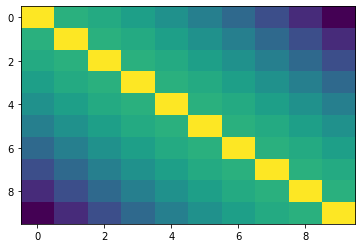

In [405]:
plt.imshow(C,aspect='auto')

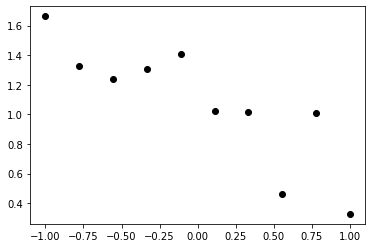

In [406]:
zero_mean = np.zeros((N))
f = np.random.multivariate_normal(zero_mean,C)
plt.plot(trainx,f,'ko')

## Predict the function

In [407]:
testN = 100
testx = np.linspace(-1,2,testN)
testC = np.zeros((testN,N))
testCC = np.zeros((testN,testN))
for n in range(testN):
    for m in range(N):
        testC[n,m] = covyy(testx[n],trainx[m])
    for m in range(testN):
        testCC[n,m] = covyy(testx[n],testx[m])

Text(0.5, 1.0, 'Function estimates')

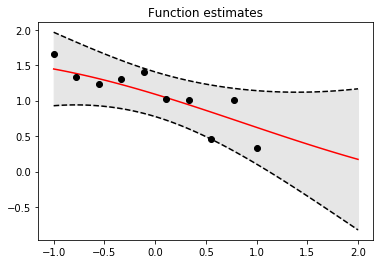

In [408]:
# predictive mean
postMu = np.dot(np.dot(testC,np.linalg.inv(C)),f)
postCov = testCC - np.dot(np.dot(testC,np.linalg.inv(C)),testC.T)
m = postMu
upper = postMu+3*np.sqrt(np.diag(postCov))
lower = postMu-3*np.sqrt(np.diag(postCov))

plt.figure()
plt.plot(testx,upper,'k--')
plt.plot(testx,lower,'k--')
ax = plt.gca()
ax.fill_between(testx,upper,lower,color = [0.9,0.9,0.9])
plt.plot(testx,m,'r')
plt.plot(trainx,f,'ko')
plt.title("Function estimates")

## Predict the gradients

In [409]:
testCg = np.zeros((testN,N))
testCCg = np.zeros((testN,testN))
for n in range(testN):
    for m in range(N):
        testCg[n,m] = covdy(testx[n],trainx[m])
    for m in range(testN):
        testCCg[n,m] = covdd(testx[n],testx[m])

Text(0.5, 1.0, 'Gradient estimates')

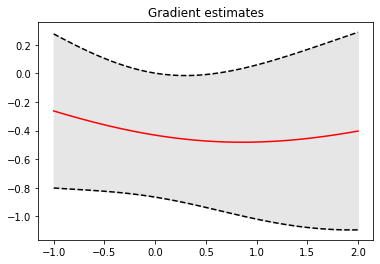

In [410]:
postMu = np.dot(np.dot(testCg,np.linalg.inv(C)),f)
postCov = testCCg - np.dot(np.dot(testCg,np.linalg.inv(C)),testCg.T)

m = postMu
upper = postMu+3*np.sqrt(np.diag(postCov))
lower = postMu-3*np.sqrt(np.diag(postCov))

plt.figure()
plt.plot(testx,upper,'k--')
plt.plot(testx,lower,'k--')
ax = plt.gca()
ax.fill_between(testx,upper,lower,color = [0.9,0.9,0.9])
plt.plot(testx,m,'r')
plt.title('Gradient estimates')

In [411]:
# compute the probability of a positive gradient
from scipy.stats import norm
prob_pos = 1 - norm.cdf(0,postMu,np.sqrt(np.diag(postCov)))

Text(0.5, 1.0, 'Probability of +ve gradient')

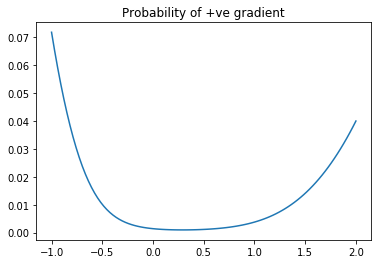

In [412]:
plt.figure()
plt.plot(testx,prob_pos)
plt.title("Probability of +ve gradient")

## Try with a ROI

In [338]:
import os,sys

qcb_root = '/Users/simon/University of Glasgow/Vinny Davies - CLDS Metabolomics Project/TopNvsTopNroi/QCB/'


mzml_QCB_TopN = os.path.join(qcb_root,'from_controller_TopN_QCB.mzML')
mzml_QCB_TopN_Roi = os.path.join(qcb_root,'from_controller_ROI_QCB.mzML')
mzml_QCB_fullscan = os.path.join(qcb_root,'QCB_22May19_1.mzML')

sys.path.append('/Users/simon/git/vimms')

In [339]:
from vimms.Roi import make_roi


In [340]:
good,bad = make_roi(mzml_QCB_fullscan)

18


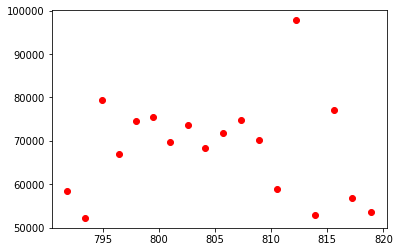

In [341]:
example_roi = good[909] # 3
print(len(example_roi.mz_list))
plt.plot(example_roi.rt_list,example_roi.intensity_list,'ro')
totalN = len(example_roi.mz_list)

0.9999647605129944
0.999868119936225
0.029086963277415223
0.9821252972793548
1.4690434033681754e-05
0.003353850836142591
0.998040179009281
0.44962524179400176
0.0004100979709608099
0.975629348033763
0.08463575968941295
0.6218801360045212
0.11600475345951189
5.47089158975389e-05


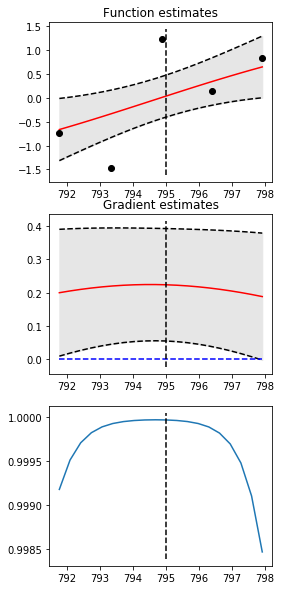

In [342]:
N = 5 # window width - needs to be odd
testN = 20
pos_probs = []
for i in range(int(np.floor(N/2))):
    pos_probs.append(0.5)

plots = False
mid_point = int(np.floor(testN/2))
for i,start_pos in enumerate(range(0,totalN - N + 1)):
    if i == 0:
        plots = True
    else:
        plots = False
    trainx = np.array(example_roi.rt_list[start_pos:start_pos + N])
    testx = np.linspace(trainx[0],trainx[-1],testN)
    C = np.zeros((N,N))
    for n in range(N):
        for m in range(N):
            C[n,m] = covyy(trainx[n],trainx[m])
    noise_ss = 0.1
    C += noise_ss*np.eye(N)
    f = np.array(np.log(example_roi.intensity_list[start_pos:start_pos + N]))
    f -= f.mean()
    f /= f.std()
    
    
    testC = np.zeros((testN,N))
    testCC = np.zeros((testN,testN))
    for n in range(testN):
        for m in range(N):
            testC[n,m] = covyy(testx[n],trainx[m])
        for m in range(testN):
            testCC[n,m] = covyy(testx[n],testx[m])
            
    postMu = np.dot(np.dot(testC,np.linalg.inv(C)),f)
    postCov = testCC - np.dot(np.dot(testC,np.linalg.inv(C)),testC.T)
    m = postMu
    upper = postMu+3*np.sqrt(np.diag(postCov))
    lower = postMu-3*np.sqrt(np.diag(postCov))

    if plots:
        plt.figure(figsize=(4,10))
        plt.subplot(3,1,1)
        plt.plot(testx,upper,'k--')
        plt.plot(testx,lower,'k--')
        ax = plt.gca()
        ax.fill_between(testx,upper,lower,color = [0.9,0.9,0.9])
        plt.plot(testx,m,'r')
        plt.plot(trainx,f,'ko')
        plt.title("Function estimates")
        plt.plot([testx[mid_point],testx[mid_point]],plt.ylim(),'k--')


    
    
    testCg = np.zeros((testN,N))
    testCCg = np.zeros((testN,testN))
    for n in range(testN):
        for m in range(N):
            testCg[n,m] = covdy(testx[n],trainx[m])
        for m in range(testN):
            testCCg[n,m] = covdd(testx[n],testx[m])
        
    postMu = np.dot(np.dot(testCg,np.linalg.inv(C)),f)
    postCov = testCCg - np.dot(np.dot(testCg,np.linalg.inv(C)),testCg.T)

    m = postMu
    upper = postMu+3*np.sqrt(np.diag(postCov))
    lower = postMu-3*np.sqrt(np.diag(postCov))
    
    if plots:
        plt.subplot(3,1,2)
        plt.plot(testx,upper,'k--')
        plt.plot(testx,lower,'k--')
        ax = plt.gca()
        ax.fill_between(testx,upper,lower,color = [0.9,0.9,0.9])
        plt.plot(testx,m,'r')
        plt.plot(testx,np.zeros_like(testx),'b--')
        plt.title('Gradient estimates')
        plt.plot([testx[mid_point],testx[mid_point]],plt.ylim(),'k--')


    
    prob_pos = 1 - norm.cdf(0,postMu,np.sqrt(np.diag(postCov)))
    if plots:
        plt.subplot(3,1,3)
        plt.plot(testx,prob_pos)
        plt.plot([testx[mid_point],testx[mid_point]],plt.ylim(),'k--')
    pos_probs.append(prob_pos[mid_point])
    print(prob_pos[mid_point])
for i in range(int(np.floor(N/2))):
    pos_probs.append(0.5)

plt.savefig('individual.png')

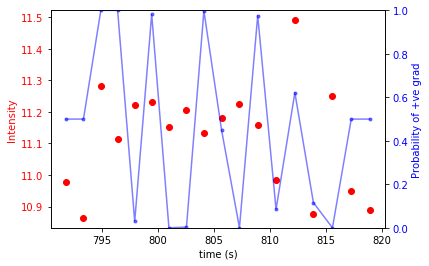

In [343]:

fig, ax1 = plt.subplots()

ax1.set_xlabel('time (s)')
ax1.set_ylabel('Intensity', color='r')
ax1.plot(example_roi.rt_list, np.log(example_roi.intensity_list), 'ro')
ax1.tick_params(axis='y', labelcolor='r')


ax2 = ax1.twinx()
ax2.plot(example_roi.rt_list,pos_probs,'b.-',alpha = 0.5)
ax2.tick_params(axis='y', labelcolor='b')
ax2.set_ylabel('Probability of +ve grad', color='b')
ax2.set_ylim([0,1])

plt.savefig('grad_example.png')